X_train shape: (20999, 1, 2)
y_train_stress shape: (20999, 13)
y_train_deformation shape: (20999, 13)
Epoch 1/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 6.0032e-05 - mae: 0.0032 - val_loss: 8.6776e-07 - val_mae: 7.2839e-04
Epoch 2/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.8090e-07 - mae: 6.9200e-04 - val_loss: 6.7793e-07 - val_mae: 6.3358e-04
Epoch 3/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.7817e-07 - mae: 6.3814e-04 - val_loss: 6.3679e-07 - val_mae: 6.1787e-04
Epoch 4/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.7967e-07 - mae: 6.3705e-04 - val_loss: 6.2312e-07 - val_mae: 5.9565e-04
Epoch 5/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.5480e-07 - mae: 6.2407e-04 - val_loss: 7.9647e-07 - val_mae: 7.0226e-04
Epoch 6/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.7971e-07 - mae: 6.4048e-04 - val_loss: 7.0974e-07 - val_mae: 6.4756e-04
Epoch 7/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 7.0233e-07 - mae: 6.4859e-04 - 

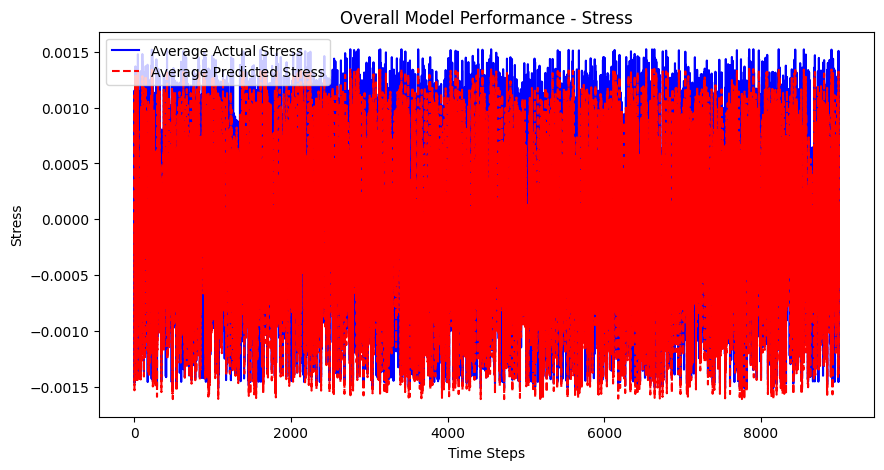

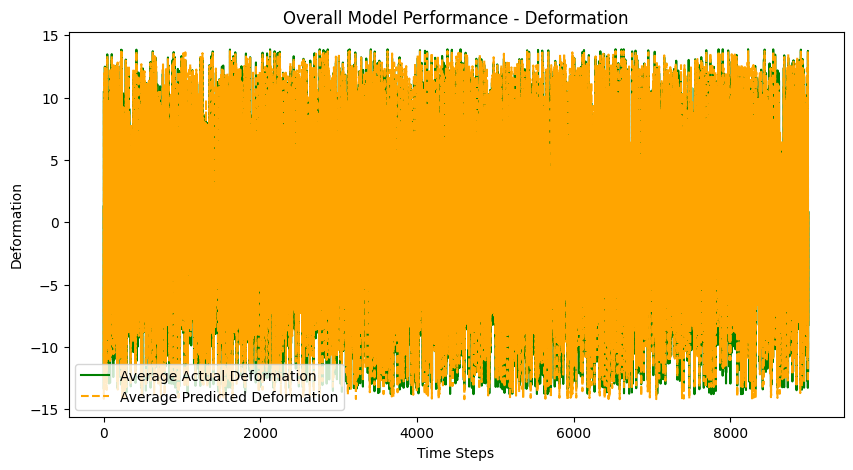

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/2d-50k.xlsx'
data = pd.read_excel(file_path)

# Separate input features (time, force) and output variables (stress for 14 nodes and deformation for 14 nodes)
X = data[['Time[s]', 'Force[N]']]
stress_columns = [f'S{i}' for i in range(2, 15)]
deformation_columns = [f'D{i}[mm]' for i in range(2, 15)]

y_stress = data[stress_columns]
y_deformation = data[deformation_columns]

# Normalize the input features using Z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input data for Conv1D (samples, time steps, features)
X_scaled = np.expand_dims(X_scaled, axis=1)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train_stress, y_test_stress = train_test_split(X_scaled, y_stress, test_size=0.3, random_state=42)
_, _, y_train_deformation, y_test_deformation = train_test_split(X_scaled, y_deformation, test_size=0.3, random_state=42)

def create_cnn_model(input_shape, output_size):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(output_size))  # Output layer adjusted for multiple nodes
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Double-check shapes before calling the model
print("X_train shape:", X_train.shape)
print("y_train_stress shape:", y_train_stress.shape)
print("y_train_deformation shape:", y_train_deformation.shape)

# Initialize and train CNN model for stress
cnn_stress = create_cnn_model(X_train.shape[1:], y_train_stress.shape[1])
history_stress = cnn_stress.fit(X_train, y_train_stress, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Initialize and train CNN model for deformation
cnn_deformation = create_cnn_model(X_train.shape[1:], y_train_deformation.shape[1])
history_deformation = cnn_deformation.fit(X_train, y_train_deformation, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Predict and evaluate for stress
y_pred_stress = cnn_stress.predict(X_test)
for i in range(13):
    mse_stress, rmse_stress, mae_stress, r2_stress = evaluate_model(y_test_stress.iloc[:, i], y_pred_stress[:, i])
    print(f'Stress Node {i+1} - MSE: {mse_stress}, RMSE: {rmse_stress}, MAE: {mae_stress}, R²: {r2_stress}')

# Predict and evaluate for deformation
y_pred_deformation = cnn_deformation.predict(X_test)
for i in range(13):
    mse_deformation, rmse_deformation, mae_deformation, r2_deformation = evaluate_model(y_test_deformation.iloc[:, i], y_pred_deformation[:, i])
    print(f'Deformation Node {i+1} - MSE: {mse_deformation}, RMSE: {rmse_deformation}, MAE: {mae_deformation}, R²: {r2_deformation}')

# Plot performance (Average Predictions for Overall Stress and Deformation)
avg_actual_stress = np.mean(y_test_stress.values, axis=1)
avg_predicted_stress = np.mean(y_pred_stress, axis=1)
avg_actual_deformation = np.mean(y_test_deformation.values, axis=1)
avg_predicted_deformation = np.mean(y_pred_deformation, axis=1)

# Stress Plot
plt.figure(figsize=(10, 5))
plt.plot(avg_actual_stress, label='Average Actual Stress', color='blue')
plt.plot(avg_predicted_stress, label='Average Predicted Stress', color='red', linestyle='dashed')
plt.title('Overall Model Performance - Stress')
plt.xlabel('Time Steps')
plt.ylabel('Stress')
plt.legend()
plt.show()

# Deformation Plot
plt.figure(figsize=(10, 5))
plt.plot(avg_actual_deformation, label='Average Actual Deformation', color='green')
plt.plot(avg_predicted_deformation, label='Average Predicted Deformation', color='orange', linestyle='dashed')
plt.title('Overall Model Performance - Deformation')
plt.xlabel('Time Steps')
plt.ylabel('Deformation')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Average Metrics Across Nodes
def evaluate_average_metrics(y_true, y_pred):
    rmse_list, mae_list, r2_list = [], [], []
    for i in range(y_true.shape[1]):  # Loop over each node
        rmse_list.append(np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i])))
        mae_list.append(mean_absolute_error(y_true[:, i], y_pred[:, i]))
        r2_list.append(r2_score(y_true[:, i], y_pred[:, i]))

    avg_rmse = np.mean(rmse_list)
    avg_mae = np.mean(mae_list)
    avg_r2 = np.mean(r2_list)

    return avg_rmse, avg_mae, avg_r2

# Compute average metrics across all nodes for stress and deformation
avg_rmse_stress, avg_mae_stress, avg_r2_stress = evaluate_average_metrics(y_test_stress.values, y_pred_stress)
avg_rmse_deformation, avg_mae_deformation, avg_r2_deformation = evaluate_average_metrics(y_test_deformation.values, y_pred_deformation)

print("Average Metrics Across Nodes:")
print(f"Stress - RMSE: {avg_rmse_stress}, MAE: {avg_mae_stress}, R²: {avg_r2_stress}")
print(f"Deformation - RMSE: {avg_rmse_deformation}, MAE: {avg_mae_deformation}, R²: {avg_r2_deformation}")

# 2. Metrics for Averaged Stress and Deformation
avg_actual_stress = np.mean(y_test_stress.values, axis=1)
avg_predicted_stress = np.mean(y_pred_stress, axis=1)
avg_actual_deformation = np.mean(y_test_deformation.values, axis=1)
avg_predicted_deformation = np.mean(y_pred_deformation, axis=1)

# Calculate metrics on averaged values for stress and deformation
overall_rmse_stress = np.sqrt(mean_squared_error(avg_actual_stress, avg_predicted_stress))
overall_mae_stress = mean_absolute_error(avg_actual_stress, avg_predicted_stress)
overall_r2_stress = r2_score(avg_actual_stress, avg_predicted_stress)

overall_rmse_deformation = np.sqrt(mean_squared_error(avg_actual_deformation, avg_predicted_deformation))
overall_mae_deformation = mean_absolute_error(avg_actual_deformation, avg_predicted_deformation)
overall_r2_deformation = r2_score(avg_actual_deformation, avg_predicted_deformation)

print("\nMetrics for Averaged Stress and Deformation:")
print(f"Stress - RMSE: {overall_rmse_stress}, MAE: {overall_mae_stress}, R²: {overall_r2_stress}")
print(f"Deformation - RMSE: {overall_rmse_deformation}, MAE: {overall_mae_deformation}, R²: {overall_r2_deformation}")


Average Metrics Across Nodes:
Stress - RMSE: 0.00041143946566948235, MAE: 0.0002535559194113681, R²: 0.7059652003762884
Deformation - RMSE: 0.7393378648666189, MAE: 0.5375473994085063, R²: 0.9881083667817543

Metrics for Averaged Stress and Deformation:
Stress - RMSE: 0.0003992800469095865, MAE: 0.00023936618574573837, R²: 0.7150199416950657
Deformation - RMSE: 0.6563854761306502, MAE: 0.47358353025493116, R²: 0.9907405006776924


<ipython-input-5-055b82d31a2e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cluster'] = kmeans.fit_predict(X_scaled[:, 0, :])  # Clustering on scaled input data


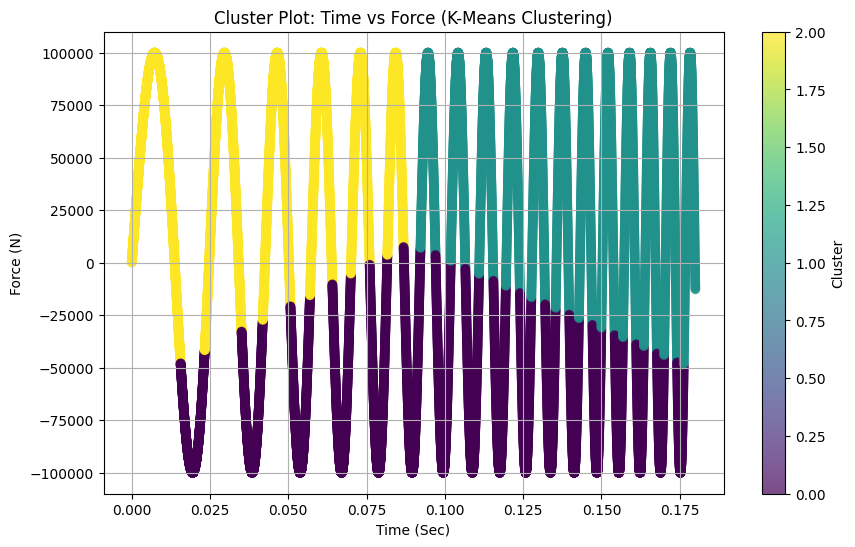

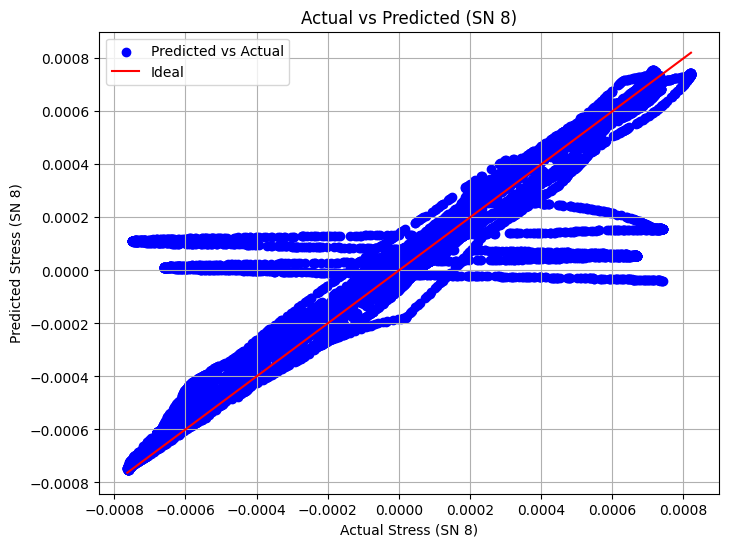

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# K-Means Clustering on Time and Force
kmeans = KMeans(n_clusters=3, random_state=42)
X['Cluster'] = kmeans.fit_predict(X_scaled[:, 0, :])  # Clustering on scaled input data

# Plotting the clusters (Time vs Force)
plt.figure(figsize=(10, 6))
plt.scatter(data['Time[s]'], data['Force[N]'], c=X['Cluster'], cmap='viridis', alpha=0.7)
plt.title('Cluster Plot: Time vs Force (K-Means Clustering)')
plt.xlabel('Time (Sec)')
plt.ylabel('Force (N)')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()

# Assuming `y_pred_stress` contains predictions and we are plotting for Node `SN 8` (index 0 for demonstration)
node_index = 0  # Adjust this for different nodes (e.g., 0 for SN 8)

# Actual vs Predicted Plot for SN 8
plt.figure(figsize=(8, 6))
plt.scatter(y_test_stress.iloc[:, node_index], y_pred_stress[:, node_index], color='blue', label='Predicted vs Actual')
plt.plot([min(y_test_stress.iloc[:, node_index]), max(y_test_stress.iloc[:, node_index])],
         [min(y_test_stress.iloc[:, node_index]), max(y_test_stress.iloc[:, node_index])], color='red', label='Ideal')
plt.title('Actual vs Predicted (SN 8)')
plt.xlabel('Actual Stress (SN 8)')
plt.ylabel('Predicted Stress (SN 8)')
plt.legend()
plt.grid(True)
plt.show()


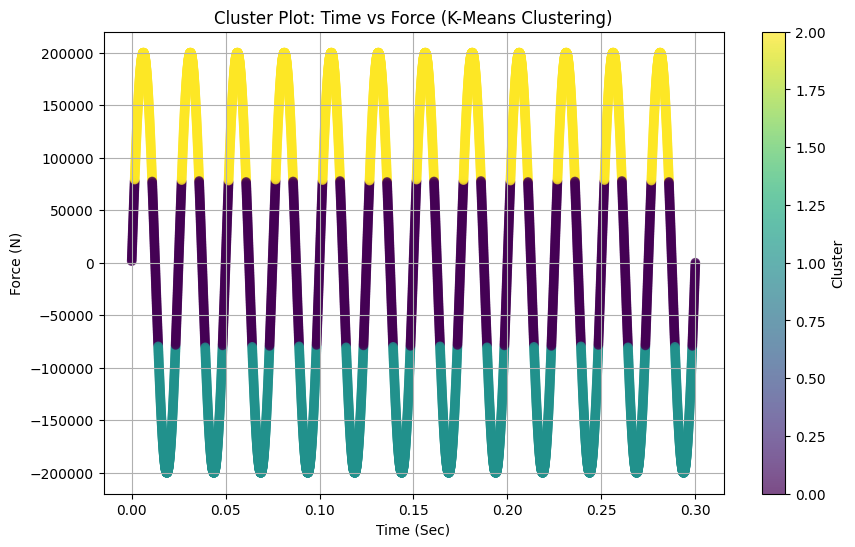

In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means to cluster the data
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)  # Assigning each point to a cluster

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X['Time(Sec)'], X['Force(N)'], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.title('Cluster Plot: Time vs Force (K-Means Clustering)')
plt.xlabel('Time (Sec)')
plt.ylabel('Force (N)')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()


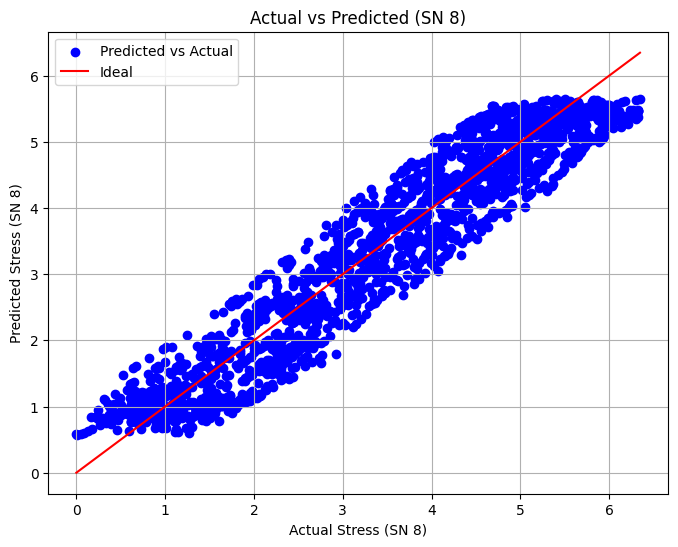

In [ ]:
# Actual vs Predicted Plot for SN 8
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], predictions[:, 0], color='blue', label='Predicted vs Actual')
plt.plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], color='red', label='Ideal')
plt.title('Actual vs Predicted (SN 8)')
plt.xlabel('Actual Stress (SN 8)')
plt.ylabel('Predicted Stress (SN 8)')
plt.legend()
plt.grid(True)
plt.show()


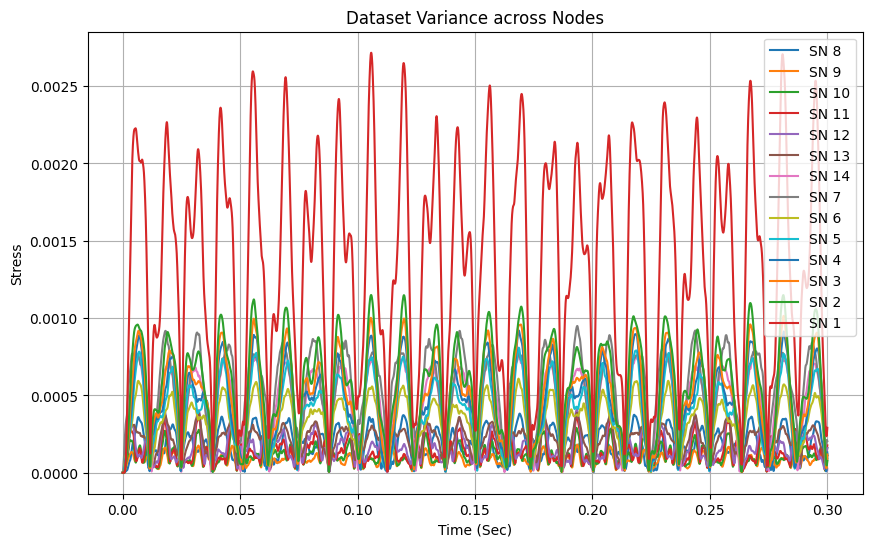

In [ ]:
# Dataset Variance Graph across All Nodes
plt.figure(figsize=(10, 6))
for node in ['SN 8', 'SN 9', 'SN 10', 'SN 11', 'SN 12', 'SN 13', 'SN 14', 'SN 7', 'SN 6', 'SN 5', 'SN 4', 'SN 3', 'SN 2', 'SN 1']:
    plt.plot(df['Time(Sec)'], df[node], label=f'{node}')

plt.title('Dataset Variance across Nodes')
plt.xlabel('Time (Sec)')
plt.ylabel('Stress')
plt.legend()
plt.grid(True)
plt.show()
